In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import seaborn as sns

##### read in the files to document

In [2]:
prompt = pd.read_csv('cleanedpromptALL.csv')

In [3]:
photo = pd.read_csv('photoALL.csv')

In [4]:
profile = pd.read_csv('profileALL.csv')

In [5]:
tagline = pd.read_csv('taglineALL.csv')

In [6]:
users = pd.read_csv('userALL.csv')

In [7]:
prompt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4948 entries, 0 to 4947
Columns: 394 entries, id to zero
dtypes: float64(386), int64(4), object(4)
memory usage: 14.9+ MB


##### got rid of duplicate user prompts (i.g users with many prompts)

In [8]:
prompt = prompt[prompt['deleted_at'].isna()]

In [9]:
prompt = prompt[['id','user_id','deleted_at','wordcount','Topic','compound','scammer']]

##### most useful columns in profile dataset

In [10]:
# just deleted verified from profile status to test
profile = profile[['id','user_id','pose_id','created_at','deleted_at', 'analyze_data', 'scammer']]

##### getting rid of duplicate user ids on files that should not have more than 1

In [11]:
nonduplicateprompt = prompt.duplicated(subset=['user_id'], keep='last')
newprompt = prompt[list(map(operator.not_, nonduplicateprompt))]

In [12]:
nonduplicateprofile = profile.duplicated(subset=['user_id'], keep='last')
newprofile = profile[list(map(operator.not_, nonduplicateprofile))]

In [13]:
from functools import reduce

##### joining files together; left out photo and tagline for now

In [14]:
dfs = [newprofile, users, newprompt]

In [15]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='user_id'), dfs)

In [16]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 0 to 867
Data columns (total 74 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_x                     868 non-null    int64  
 1   user_id                  868 non-null    int64  
 2   pose_id                  868 non-null    int64  
 3   created_at_x             868 non-null    object 
 4   deleted_at_x             14 non-null     object 
 5   analyze_data             42 non-null     object 
 6   scammer_x                868 non-null    object 
 7   fb_id                    122 non-null    float64
 8   gf_id                    744 non-null    object 
 9   ak_id                    2 non-null      float64
 10  auth_type                474 non-null    object 
 11  device_token             370 non-null    object 
 12  first_name               868 non-null    object 
 13  last_name                868 non-null    object 
 14  email                    4

##### fill in NAN values with 0s; might change to -1 (?) later

In [17]:
df_falsefull = df_final.fillna(0)

In [18]:
df_falsefull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 0 to 867
Data columns (total 74 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_x                     868 non-null    int64  
 1   user_id                  868 non-null    int64  
 2   pose_id                  868 non-null    int64  
 3   created_at_x             868 non-null    object 
 4   deleted_at_x             868 non-null    object 
 5   analyze_data             868 non-null    object 
 6   scammer_x                868 non-null    object 
 7   fb_id                    868 non-null    float64
 8   gf_id                    868 non-null    object 
 9   ak_id                    868 non-null    float64
 10  auth_type                868 non-null    object 
 11  device_token             868 non-null    object 
 12  first_name               868 non-null    object 
 13  last_name                868 non-null    object 
 14  email                    8

##### grabbing columns that can be used for random forests (no complicated string data used)

In [19]:
mycolumns = df_falsefull.describe().columns

In [20]:
mycolumns

Index(['id_x', 'user_id', 'pose_id', 'fb_id', 'ak_id', 'lat', 'lng', 'age',
       'drip_state', 'gated', 'height_ft', 'height_in', 'dating_interest',
       'pref_age_low', 'pref_age_high', 'pref_search_radius', 'notif_match',
       'notif_message', 'notif_reminders', 'notif_allowed', 'notif_notes',
       'auto_archive_notes', 'distance_off', 'app_version', 'p_note_balance',
       'p_enabled', 'p_ward_hop', 'p_ninja_mode', 'p_no_ads', 'gender_id',
       'acct_status_id', 'paused', 'pref_height_min', 'pref_height_max',
       'search_by_country', 'is_ig_connected', 'id_y', 'deleted_at',
       'wordcount', 'Topic', 'compound'],
      dtype='object')

In [21]:
# 'acct_status_id', 'drip_state','app_version','notif_allowed'

In [22]:
mycolumns = mycolumns.drop(['id_x','user_id','acct_status_id', 'drip_state','app_version','notif_allowed'])

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [24]:
y = df_falsefull['scammer']

In [25]:
X = df_falsefull[mycolumns]

##### double checking no duplicate user rows (868 unique users)

In [26]:
df_falsefull.user_id.value_counts()

927739     1
1015731    1
1012292    1
479916     1
1120713    1
          ..
1146199    1
1089775    1
529743     1
947533     1
45056      1
Name: user_id, Length: 868, dtype: int64

##### begin training model

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, random_state=42)

In [28]:
mytrees = RandomForestClassifier(min_samples_leaf = 20, random_state=101)

In [29]:
mytrees.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=20, random_state=101)

##### predicting probabilities for ROC curve

In [30]:
rf_proba = mytrees.predict_proba(X_test)

In [31]:
rf_proba

array([[0.2464978 , 0.7535022 ],
       [0.25955697, 0.74044303],
       [0.90675534, 0.09324466],
       ...,
       [0.71509111, 0.28490889],
       [0.74629171, 0.25370829],
       [0.96710461, 0.03289539]])

In [32]:
booly_test = y_test.apply(lambda x: x == 'Yes')
newy_test = booly_test.astype(int)

In [33]:
#booly_test

In [34]:
#newy_test

In [35]:
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [36]:
rf_proba

array([[0.2464978 , 0.7535022 ],
       [0.25955697, 0.74044303],
       [0.90675534, 0.09324466],
       ...,
       [0.71509111, 0.28490889],
       [0.74629171, 0.25370829],
       [0.96710461, 0.03289539]])

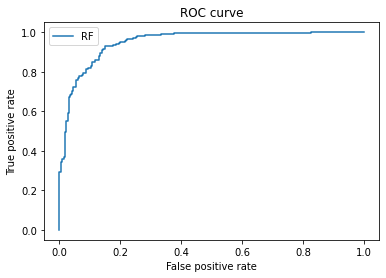

In [37]:
y_pred_rf = rf_proba[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(newy_test, y_pred_rf)

plt.figure(1)
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

##### Converting probabilities into values ( 

In [38]:
my_predictions = pd.Series(rf_proba[:, 1]).apply(lambda x: 'Yes' if (x > .7) else 'No')

In [39]:
print(confusion_matrix(y_test, my_predictions))

[[252   8]
 [ 90 171]]


In [40]:
print(classification_report(y_test, my_predictions))

              precision    recall  f1-score   support

          No       0.74      0.97      0.84       260
         Yes       0.96      0.66      0.78       261

    accuracy                           0.81       521
   macro avg       0.85      0.81      0.81       521
weighted avg       0.85      0.81      0.81       521



In [41]:
importances = mytrees.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

In [42]:
newsorted = sorted_indices[0:20]

In [43]:
importances[newsorted]

array([1.76985583e-01, 1.29216006e-01, 1.28298133e-01, 1.15536821e-01,
       1.15483517e-01, 9.31190204e-02, 6.73240006e-02, 4.52204629e-02,
       4.07669345e-02, 2.21191840e-02, 1.54002021e-02, 1.48965242e-02,
       8.26318367e-03, 7.83099991e-03, 7.41568532e-03, 6.02993275e-03,
       4.60588498e-03, 1.15707359e-03, 1.83367676e-04, 1.45149974e-04])

In [44]:
X_train.columns[newsorted]

Index(['age', 'pref_age_high', 'dating_interest', 'pref_age_low', 'lng',
       'pref_search_radius', 'lat', 'id_y', 'height_ft', 'wordcount',
       'pref_height_max', 'height_in', 'pref_height_min', 'notif_reminders',
       'gender_id', 'Topic', 'compound', 'pose_id', 'distance_off', 'fb_id'],
      dtype='object')

In [45]:
feature_importances = pd.DataFrame(mytrees.feature_importances_, \
                                   index =X_train.columns,  \
                                   columns=['importance']).sort_values('importance', ascending=False)

In [46]:
feature_importances.head(20)

,importance
age,0.176986
pref_age_high,0.129216
dating_interest,0.128298
pref_age_low,0.115537
lng,0.115484
pref_search_radius,0.093119
lat,0.067324
id_y,0.045220
height_ft,0.040767
wordcount,0.022119


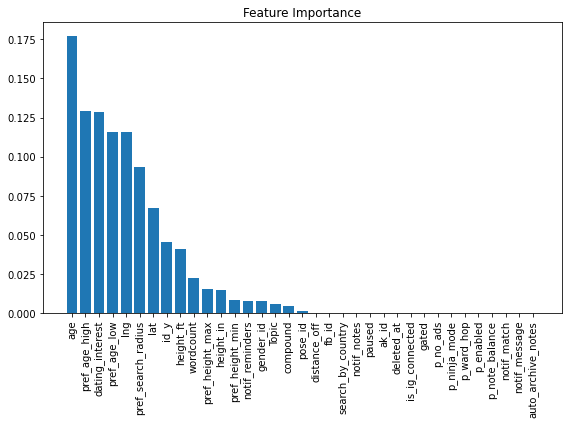

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

plt.title('Feature Importance')
plt.bar(range(21), importances[newsorted], align='center')
plt.xticks(range(21), X_train.columns[newsorted], rotation=90)
plt.tight_layout()
plt.show()

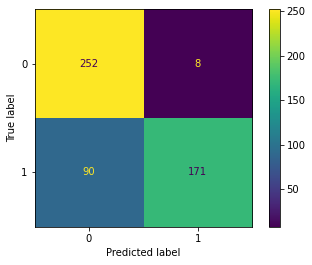

In [48]:
cm = confusion_matrix(y_test, my_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

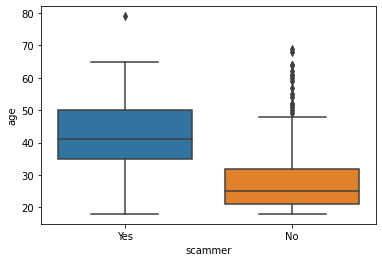

In [51]:
sns.boxplot(df_falsefull['scammer'],df_falsefull['age'])

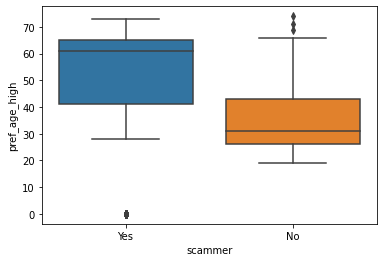

In [52]:
sns.boxplot(df_falsefull['scammer'],df_falsefull['pref_age_high'])

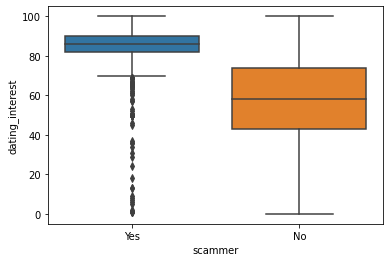

In [53]:
sns.boxplot(df_falsefull['scammer'],df_falsefull['dating_interest'])

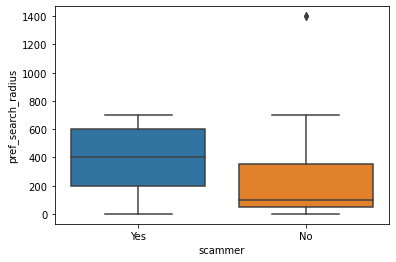

In [54]:
sns.boxplot(df_falsefull['scammer'],df_falsefull['pref_search_radius'])

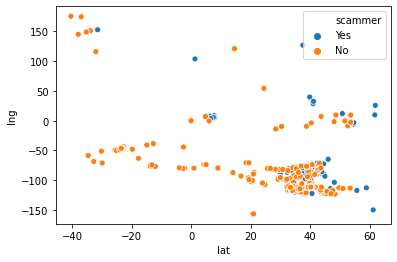

In [56]:
sns.scatterplot(df_falsefull['lat'],df_falsefull['lng'], hue=df_falsefull['scammer'])